In [38]:
#carregando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer


 # Seleção de Features e Teste do Modelo para Indicação de Leads

 ## Nesta abordagem para seleção de features e teste do modelo foram utilizadas as seguintes técnicas
 ### 1. Remoção de colunas com campos acima de 99,5% de dados faltantes
 ### 2. Agrupamento das variáveis
 ### 3. Préprocessamento com OneHotEnconding, Preenchimento de dados nulos, Seleção de features por correlação;
 ### 4. Teste de um modelo utilizando Clusterização
 ### 5. Teste de um modelo utilizando somente Nearest Neighbors

In [2]:
#carrega dados de mercado
df_market = pd.read_csv('../data/estaticos_market.csv')

In [3]:
#remoção coluna Unnamed
df_market = df_market.drop('Unnamed: 0',axis=1)

In [4]:
#criação dataframe auxiliar e remoção de features acima de 99,5%
df_aux = pd.DataFrame(data={
    'colunas':df_market.columns,
    'missing':df_market.isna().sum(),
    'qtd':df_market.shape[0]
})
df_aux['tx_miss'] = round(df_aux['missing']/df_aux['qtd'],2)
df_market = df_market.drop(list(df_aux.query(f'tx_miss >= {0.995}').colunas),axis=1)

In [5]:
#coloca id como índice
df_market = df_market.set_index('id')

In [151]:
#Funções
def preprocessing(df,col_group,nan_resolve,threshold):
    """Preprocessamento das variáveis. Esta função realiza o enconding das categóricas, preenchimento das NaNs com a mediana e a seleção de features
    utilizando VarianceThreshold 

    Args:
        df (DataFrame): dataframe que será processado
        col_group (List): lista com os grupos de colunas que serão utilizados no préprocessamento
        nan_resolve ([Str]): Técnica utilizada para preenhcer NaN - 'median'ou 'none'
        threshold ([Float]): Limite de variância para seleção de features

    Returns:
        DataFrame: Dataframe préprocessado
    """    
    print('--Criando dataframe com as colunas--')
    df_empresa = df[col_group]

    print('--Aplicando OneHotEnconding--')
    df_encoded = pd.get_dummies(df_empresa)

    if nan_resolve == 'median':
        df_encoded = df_encoded.fillna(df_encoded.median())
    else:
        pass

    print('--Aplicando MinMaxScaler--')
    minmax = MinMaxScaler()
    minmax_transformed = minmax.fit_transform(df_encoded)
    df_encoded_std = pd.DataFrame(data=minmax_transformed,columns=df_encoded.columns)

    print(df_encoded_std.var())
    print('--Aplicando VarianceThreshold--')
    select_by_variance = VarianceThreshold(threshold=threshold)
    fitted_model = select_by_variance.fit(df_encoded_std)
    features = df_encoded_std.columns[fitted_model.get_support()]

    df_return = df_encoded_std[features]

    return df_return

#função para recomendar leads
def recommender(df_test,df_market,modelo):
    """Função para gerar recomendação de leads com base no dataframe recebido e utilizando o modelo NearestNeighbors

    Args:
        df_test (DataFrame): Dataframe com a base de leads do cliente
        df_market (DataFrame): Dataframe utilizando para treinamento
        modelo (NearestNeighbors): Fit do modelo

    Returns:
        Tupple: Serie - Ids recomendados pelo modelo
                Int - Total de leads recomendados pelo modelo
                Serie - Distancias dos leads recomendados

    """    
    distance, index = modelo.kneighbors(df_test)
    distance = distance.flatten()
    index = index.flatten()
    recomendados = df_market.iloc[index]
    recomendados['distance'] = distance
    recomendados = recomendados.sort_values(by=['distance'],ascending=False)
    recomendados = recomendados[recomendados['distance']<=0.1]
    return (recomendados['id'],recomendados.shape[0],recomendados['distance'])

def get_metrics(ids_true, ids_pred):
    """Função para avaliar as métricas do modelo (Acurácia, Precisão e Recall)

    Args:
        ids_true (Serie): Ids da base de teste
        ids_pred (Serie): Ids recomendados pelo modelo

    Returns:
        Tupple: 
        Float - acurácia do modelo
        Float - Precisão do modelo
        Recall - Recall do modelo
    """    
    tp = len(set(ids_true) & set(ids_pred))
    fp = ids_pred.shape[0] - tp
    fn = ids_true.shape[0] - tp
    tn = df_train.shape[0] - ids_pred.shape[0]
    p = ids_true.shape[0]
    n = df_train.shape[0] - p
    accuracy = (tp)/p
    precision = tp/ids_pred.shape[0]
    recall = tp/(tp+fn)
    return (accuracy,precision,recall)

 ## Teste de seleção de features colocando o ramo da empresa como variável alvo

 ## Qualificação das variáveis
 1. As variáveis foram agrupadas em 7 grupos
 2. As features serão avaliadas isoladamente dentro de cada grupo
 4. Será feita uma seleção de feature utilizando VarianceThreshold ou Remoção das maiores correlações.

In [7]:
#convertendo variaveis object para bool
convert_to_bool = [
'fl_optante_simei',
'fl_optante_simples',
'fl_passivel_iss',
'fl_rm',
'fl_sa',
'fl_simples_irregular',
'fl_spa',
'fl_st_especial',
'fl_telefone',
'fl_veiculo'
]
for col in convert_to_bool:
    df_market[col] = df_market[col].astype(bool)



In [8]:
info_empresa = [
'setor',
'fl_email',
'fl_mei',
'fl_telefone',
'idade_empresa_anos',
'natureza_juridica_macro',
'qt_filiais',
'sg_uf']



In [9]:
info_filiais = [
'coligada_mais_antiga_ativa',
'coligada_mais_nova_ativa',
'de_faixa_faturamento_estimado',
'de_faixa_faturamento_estimado_grupo',
'faturamento_est_coligados',
'faturamento_est_coligados_gp',
'idade_maxima_coligadas',
'idade_media_coligadas',
'idade_media_coligadas_ativas',
'idade_minima_coligadas',
'max_faturamento_est_coligados',
'max_faturamento_est_coligados_gp',
'max_filiais_coligados',
'max_funcionarios_coligados_gp',
'max_vl_folha_coligados',
'max_vl_folha_coligados_gp',
'media_faturamento_est_coligados',
'media_faturamento_est_coligados_gp',
'media_filiais_coligados',
'media_funcionarios_coligados_gp',
'media_vl_folha_coligados',
'media_vl_folha_coligados_gp',
'min_faturamento_est_coligados',
'min_faturamento_est_coligados_gp',
'min_filiais_coligados',
'min_funcionarios_coligados_gp',
'min_vl_folha_coligados',
'min_vl_folha_coligados_gp',
'qt_coligadas',
'qt_coligados',
'qt_coligados_agropecuaria',
'qt_coligados_atividade_alto',
'qt_coligados_atividade_baixo',
'qt_coligados_atividade_inativo',
'qt_coligados_atividade_medio',
'qt_coligados_atividade_mt_baixo',
'qt_coligados_ativo',
'qt_coligados_baixada',
'qt_coligados_ccivil',
'qt_coligados_centro',
'qt_coligados_comercio',
'qt_coligados_epp',
'qt_coligados_exterior',
'qt_coligados_inapta',
'qt_coligados_industria',
'qt_coligados_ltda',
'qt_coligados_matriz',
'qt_coligados_me',
'qt_coligados_mei',
'qt_coligados_nordeste',
'qt_coligados_norte',
'qt_coligados_nula',
'qt_coligados_sa',
'qt_coligados_serviço',
'qt_coligados_sudeste',
'qt_coligados_sul',
'qt_coligados_suspensa',
'qt_funcionarios_coligados',
'qt_funcionarios_coligados_gp',
'qt_ramos_coligados',
'qt_regioes_coligados',
'qt_socios_coligados',
'qt_ufs_coligados',
'sum_faturamento_estimado_coligadas',
'total_filiais_coligados',
'vl_faturamento_estimado_aux',
'vl_faturamento_estimado_grupo_aux',
'vl_folha_coligados',
'vl_folha_coligados_gp'
]



In [10]:
info_funcionarios = [
'grau_instrucao_macro_escolaridade_fundamental',
'grau_instrucao_macro_escolaridade_media',
'grau_instrucao_macro_escolaridade_superior',
'idade_acima_de_58',
'idade_ate_18',
'idade_de_19_a_23',
'idade_de_24_a_28',
'idade_de_29_a_33',
'idade_de_34_a_38',
'idade_de_39_a_43',
'idade_de_44_a_48',
'idade_de_49_a_53',
'idade_de_54_a_58',
'max_meses_servicos',
'max_meses_servicos_all',
'media_meses_servicos',
'media_meses_servicos_all',
'meses_ultima_contratacaco',
'min_meses_servicos',
'min_meses_servicos_all',
'percent_func_genero_fem',
'percent_func_genero_masc',
'qt_admitidos',
'qt_admitidos_12meses',
'qt_desligados',
'qt_desligados_12meses',
'qt_ex_funcionarios',
'qt_funcionarios',
'qt_funcionarios_12meses',
'qt_funcionarios_24meses',
'qt_funcionarios_grupo',
'total',
'tx_crescimento_12meses',
'tx_crescimento_24meses',
'tx_rotatividade'
]



In [11]:
info_ibge = [
'empsetorcensitariofaixarendapopulacao',
'nm_micro_regiao'    
]


In [12]:
info_socios = [
'idade_maxima_socios',
'idade_media_socios',
'idade_minima_socios',
'qt_socios',
'qt_socios_feminino',
'qt_socios_masculino',
'qt_socios_pep',
'qt_socios_pf',
'qt_socios_pj',
'qt_socios_pj_ativos',
'qt_socios_pj_baixados',
'qt_socios_pj_inaptos',
'qt_socios_pj_nulos',
'qt_socios_pj_suspensos',
'qt_socios_st_regular',
'qt_socios_st_suspensa',
'vl_idade_maxima_socios_pj',
'vl_idade_media_socios_pj',
'vl_idade_minima_socios_pj',    
]



In [14]:
info_transporte = [
'fl_antt',
'fl_optante_simples',
'fl_spa',
'fl_veiculo',
'qt_art',
'vl_frota',
'vl_potenc_cons_oleo_gas',
'vl_total_veiculos_leves',
'vl_total_veiculos_leves_grupo',
'vl_total_veiculos_pesados',
'vl_total_veiculos_pesados_grupo'    
]



In [15]:
info_tributaria = [
'de_saude_rescencia',
'de_saude_tributaria',
'fl_optante_simei',
'fl_passivel_iss',
'fl_simples_irregular',
'nu_meses_rescencia'
]



In [16]:
#Seleção de features do grupo Empresa
df_empresa = df_market[info_empresa]
df_empresa = preprocessing(df_market,info_empresa,'none',.1)
df_empresa.columns



--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
fl_email                                                  0.247058
fl_mei                                                    0.219868
fl_telefone                                               0.199081
idade_empresa_anos                                        0.008165
qt_filiais                                                0.002360
setor_AGROPECUARIA                                        0.006974
setor_COMERCIO                                            0.248143
setor_CONSTRUÇÃO CIVIL                                    0.051853
setor_INDUSTRIA                                           0.062359
setor_SERVIÇO                                             0.241940
natureza_juridica_macro_ADMINISTRACAO PUBLICA             0.006259
natureza_juridica_macro_CARGO POLITICO                    0.003486
natureza_juridica_macro_ENTIDADES EMPRESARIAIS            0.168587
natureza_juridica_macro_ENTIDADES S

Index(['fl_email', 'fl_mei', 'fl_telefone', 'setor_COMERCIO', 'setor_SERVIÇO',
       'natureza_juridica_macro_ENTIDADES EMPRESARIAIS',
       'natureza_juridica_macro_OUTROS', 'sg_uf_AM', 'sg_uf_MA', 'sg_uf_PI',
       'sg_uf_RN', 'sg_uf_RO'],
      dtype='object')

In [17]:
df_empresa



,fl_email,fl_mei,fl_telefone,setor_COMERCIO,setor_SERVIÇO,natureza_juridica_macro_ENTIDADES EMPRESARIAIS,natureza_juridica_macro_OUTROS,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
462293,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
462294,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
462295,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
462296,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
#Seleção de Features do grupo Funcionários
df_funcionarios = preprocessing(df_market,info_funcionarios,'none',.00)



--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
grau_instrucao_macro_escolaridade_fundamental    0.000088
grau_instrucao_macro_escolaridade_media          0.000037
grau_instrucao_macro_escolaridade_superior       0.000063
idade_acima_de_58                                0.000216
idade_ate_18                                     0.000600
idade_de_19_a_23                                 0.000079
idade_de_24_a_28                                 0.000176
idade_de_29_a_33                                 0.000081
idade_de_34_a_38                                 0.000053
idade_de_39_a_43                                 0.000064
idade_de_44_a_48                                 0.000087
idade_de_49_a_53                                 0.000082
idade_de_54_a_58                                 0.000118
max_meses_servicos                               0.003008
max_meses_servicos_all                           0.015038
media_meses_servicos                

In [19]:
df_corr = pd.DataFrame(df_funcionarios.corr().abs())
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
df_funcionarios = df_funcionarios.drop(to_drop,axis=1)



In [20]:
df_funcionarios.isna().sum()



grau_instrucao_macro_escolaridade_fundamental    437402
idade_ate_18                                     459392
idade_de_19_a_23                                 436408
max_meses_servicos                               386037
max_meses_servicos_all                           358738
percent_func_genero_fem                          386356
qt_admitidos_12meses                             358724
qt_funcionarios_grupo                            347035
tx_crescimento_12meses                           388410
tx_crescimento_24meses                           388284
tx_rotatividade                                  358724
dtype: int64

In [21]:
#Seleção de Features do Grupo Sócios
df_socios = preprocessing(df_market,info_socios,'none',.0)



--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
idade_maxima_socios          0.011661
idade_media_socios           0.009580
idade_minima_socios          0.009412
qt_socios                    0.000179
qt_socios_feminino           0.000037
qt_socios_masculino          0.001178
qt_socios_pep                0.008206
qt_socios_pf                 0.000175
qt_socios_pj                 0.000225
qt_socios_pj_ativos          0.004910
qt_socios_pj_baixados        0.003862
qt_socios_pj_inaptos         0.000873
qt_socios_pj_nulos           0.007211
qt_socios_pj_suspensos       0.001315
qt_socios_st_regular         0.000210
qt_socios_st_suspensa        0.002195
vl_idade_maxima_socios_pj    0.020980
vl_idade_media_socios_pj     0.028001
vl_idade_minima_socios_pj    0.025750
dtype: float64
--Aplicando VarianceThreshold--


In [22]:
df_corr_socios = pd.DataFrame(df_socios.corr().abs())
upper = df_corr_socios.where(np.triu(np.ones(df_corr_socios.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
df_socios = df_socios.drop(to_drop,axis=1)
df_socios.fillna(0,inplace=True)



In [23]:
df_socios



,idade_maxima_socios,qt_socios,qt_socios_feminino,qt_socios_pj,qt_socios_pj_baixados,qt_socios_pj_inaptos,qt_socios_pj_nulos,qt_socios_pj_suspensos,qt_socios_st_suspensa,vl_idade_maxima_socios_pj
0,0.379845,0.004082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.224806,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.263566,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.294574,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
462293,0.255814,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462294,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462295,0.589147,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462296,0.317829,0.016327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Seleção de Features do grupo Transporte
df_transporte = preprocessing(df_market,info_transporte,'none',.0)



--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
fl_optante_simples                 0.237744
fl_spa                             0.004751
fl_veiculo                         0.065565
qt_art                             0.000628
vl_frota                           0.000234
vl_potenc_cons_oleo_gas            0.000426
vl_total_veiculos_leves            0.000383
vl_total_veiculos_leves_grupo      0.000098
vl_total_veiculos_pesados          0.000329
vl_total_veiculos_pesados_grupo    0.000055
fl_antt_False                      0.011128
fl_antt_True                       0.007036
dtype: float64
--Aplicando VarianceThreshold--


In [25]:
df_corr_transporte = pd.DataFrame(df_transporte.corr().abs())
upper = df_corr_transporte.where(np.triu(np.ones(df_corr_transporte.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
df_transporte = df_transporte.drop(to_drop,axis=1)
df_transporte.fillna(0,inplace=True)



In [26]:
df_transporte



,fl_optante_simples,fl_spa,fl_veiculo,qt_art,vl_frota,vl_potenc_cons_oleo_gas,vl_total_veiculos_leves_grupo,vl_total_veiculos_pesados
0,1.0,0.0,0.0,0.00689,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
462293,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
462294,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
462295,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
462296,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


In [27]:
#Seleção de Features do grupo Tributario
df_tributaria = preprocessing(df_market,info_tributaria,'none',.0)



--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
fl_optante_simei                     0.236156
fl_passivel_iss                      0.244097
fl_simples_irregular                 0.004882
nu_meses_rescencia                   0.021510
de_saude_rescencia_ACIMA DE 1 ANO    0.147861
de_saude_rescencia_ATE 1 ANO         0.075624
de_saude_rescencia_ATE 3 MESES       0.000028
de_saude_rescencia_ATE 6 MESES       0.000026
de_saude_rescencia_SEM INFORMACAO    0.061481
de_saude_tributaria_AMARELO          0.158155
de_saude_tributaria_AZUL             0.175812
de_saude_tributaria_CINZA            0.119304
de_saude_tributaria_LARANJA          0.072020
de_saude_tributaria_VERDE            0.215620
de_saude_tributaria_VERMELHO         0.011981
dtype: float64
--Aplicando VarianceThreshold--


In [28]:
df_corr_tributaria = pd.DataFrame(df_tributaria.corr().abs())
upper = df_corr_tributaria.where(np.triu(np.ones(df_corr_tributaria.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
df_tributaria = df_tributaria.drop(to_drop,axis=1)
df_tributaria.fillna(0,inplace=True)



In [29]:
df_tributaria



,fl_optante_simei,fl_passivel_iss,fl_simples_irregular,nu_meses_rescencia,de_saude_rescencia_ATE 3 MESES,de_saude_rescencia_ATE 6 MESES,de_saude_tributaria_AMARELO,de_saude_tributaria_AZUL,de_saude_tributaria_LARANJA,de_saude_tributaria_VERDE,de_saude_tributaria_VERMELHO
0,0.0,1.0,0.0,0.348485,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.136364,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.393939,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.393939,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.409091,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
462293,1.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0
462294,0.0,1.0,0.0,0.348485,0.0,0.0,0.0,0.0,1.0,0.0,0.0
462295,0.0,1.0,0.0,0.348485,0.0,0.0,1.0,0.0,0.0,0.0,0.0
462296,0.0,0.0,0.0,0.303030,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
#Seleção de features do grupo IBGE
df_ibge = preprocessing(df_market,info_ibge,'none',.0)



--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
empsetorcensitariofaixarendapopulacao             0.000240
nm_micro_regiao_AGLOMERACAO URBANA DE SAO LUIS    0.089386
nm_micro_regiao_AGRESTE POTIGUAR                  0.008390
nm_micro_regiao_ALTO MEARIM E GRAJAU              0.009276
nm_micro_regiao_ALTO MEDIO CANINDE                0.009366
                                                    ...   
nm_micro_regiao_TEFE                              0.002946
nm_micro_regiao_TERESINA                          0.067928
nm_micro_regiao_UMARIZAL                          0.003006
nm_micro_regiao_VALE DO ACU                       0.007096
nm_micro_regiao_VALENCA DO PIAUI                  0.004046
Length: 74, dtype: float64
--Aplicando VarianceThreshold--


In [31]:
df_ibge



,empsetorcensitariofaixarendapopulacao,nm_micro_regiao_AGLOMERACAO URBANA DE SAO LUIS,nm_micro_regiao_AGRESTE POTIGUAR,nm_micro_regiao_ALTO MEARIM E GRAJAU,nm_micro_regiao_ALTO MEDIO CANINDE,nm_micro_regiao_ALTO MEDIO GURGUEIA,nm_micro_regiao_ALTO PARNAIBA PIAUIENSE,nm_micro_regiao_ALTO SOLIMOES,nm_micro_regiao_ANGICOS,nm_micro_regiao_BAIXA VERDE,...,nm_micro_regiao_SERIDO OCIDENTAL,nm_micro_regiao_SERIDO ORIENTAL,nm_micro_regiao_SERRA DE SANTANA,nm_micro_regiao_SERRA DE SAO MIGUEL,nm_micro_regiao_TARAUACA,nm_micro_regiao_TEFE,nm_micro_regiao_TERESINA,nm_micro_regiao_UMARIZAL,nm_micro_regiao_VALE DO ACU,nm_micro_regiao_VALENCA DO PIAUI
0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.004919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.008181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.005010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.036990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462293,0.006476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462294,0.031068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
462295,0.040681,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462296,0.035369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#Seleção de features do grupo Filiais
df_filiais = preprocessing(df_market,info_filiais,'none',.0)



--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
coligada_mais_antiga_ativa                                                      0.014863
coligada_mais_nova_ativa                                                        0.014107
faturamento_est_coligados                                                       0.000940
faturamento_est_coligados_gp                                                    0.000917
idade_maxima_coligadas                                                          0.014836
                                                                                  ...   
de_faixa_faturamento_estimado_grupo_DE R$ 300.000.000,01 A R$ 500.000.000,00    0.001128
de_faixa_faturamento_estimado_grupo_DE R$ 360.000,01 A R$ 1.500.000,00          0.102321
de_faixa_faturamento_estimado_grupo_DE R$ 4.800.000,01 A R$ 10.000.000,00       0.008694
de_faixa_faturamento_estimado_grupo_DE R$ 500.000.000,01 A 1 BILHAO DE REAIS    0.001460
de_faixa_faturam

In [33]:
df_corr_filiais = pd.DataFrame(df_filiais.corr().abs())
upper = df_corr_filiais.where(np.triu(np.ones(df_corr_filiais.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
df_filiais = df_filiais.drop(to_drop,axis=1)
df_filiais.fillna(0,inplace=True)



In [34]:
df_filiais



,coligada_mais_antiga_ativa,coligada_mais_nova_ativa,faturamento_est_coligados,min_faturamento_est_coligados,qt_coligadas,qt_coligados_agropecuaria,qt_coligados_centro,qt_coligados_comercio,qt_coligados_epp,qt_coligados_exterior,...,"de_faixa_faturamento_estimado_DE R$ 360.000,01 A R$ 1.500.000,00","de_faixa_faturamento_estimado_DE R$ 4.800.000,01 A R$ 10.000.000,00","de_faixa_faturamento_estimado_DE R$ 500.000.000,01 A 1 BILHAO DE REAIS",de_faixa_faturamento_estimado_SEM INFORMACAO,"de_faixa_faturamento_estimado_grupo_DE R$ 10.000.000,01 A R$ 30.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 100.000.000,01 A R$ 300.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 30.000.000,01 A R$ 100.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 300.000.000,01 A R$ 500.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 4.800.000,01 A R$ 10.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 500.000.000,01 A 1 BILHAO DE REAIS"
0,0.394652,0.062326,0.000064,0.000240,0.006579,0.0,0.000000,0.003676,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462293,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462294,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462295,0.225845,0.337022,0.000002,0.000708,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462296,0.449775,0.001502,0.000513,0.000071,0.248684,0.0,0.257143,0.683824,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#Criação do Dataframe com as features selecionadas
df_train = df_tributaria.join(df_empresa).join(df_transporte).join(df_socios).join(df_funcionarios).join(df_ibge).join(df_filiais)
df_train['id'] = df_market.index


In [36]:
#Preenchimento de valores nulos com 0
df_train.fillna(0,inplace=True)


# Teste do algoritmo utilizando uma clusterização dos e seleção dos vizinhos próximos por cluster

In [186]:
pca = PCA(n_components=100)
pca.fit(df_train.drop('id',axis=1))
df_pca = pca.transform(df_train.drop('id',axis=1))
df_pca = pd.DataFrame(df_pca)

In [188]:
df_pca['id'] = df_train['id']

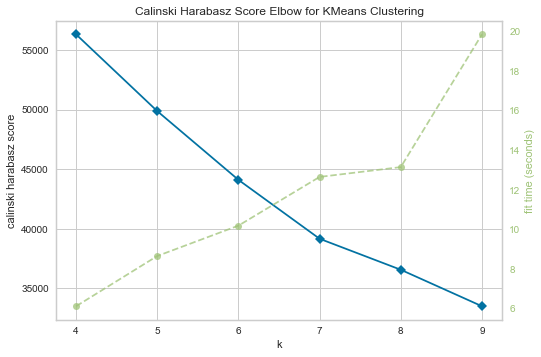

In [68]:
#Visualização da melhor quantidade de clusters
knn = KMeans()
visualizer = KElbowVisualizer(knn,k=(4,10),metric='calinski_harabasz')
visualizer.fit(df_pca)
visualizer.show()

In [172]:
#Criando clusters na quantidade recomendada utilizando calinsky_harabsz
kmeans = KMeans(n_clusters=5,n_init=10,init='k-means++')
kmeans.fit(df_pca)

KMeans(n_clusters=5)

In [173]:
#Adicionando clusters ao dataframe
df_pca['cluster'] = kmeans.labels_



 ### Teste do KNN somente com as variáveis selecionadas para a empresa

In [118]:
def get_portfolio(amostra,populacao):
    amostra = populacao[populacao['id'].isin(amostra['id'])]
    train,test = train_test_split(amostra,test_size=0.3,shuffle=True)
    return (train,test)

In [189]:
#carregamento do Portfólio para teste
portfolio_dummie_pca = df_train.sample(n=1000, replace=False, random_state=2334,weights='setor_COMERCIO')
port_1_pca = pd.read_csv('../data/estaticos_portfolio1.csv')
port_2_pca = pd.read_csv('../data/estaticos_portfolio2.csv')
port_3_pca = pd.read_csv('../data/estaticos_portfolio3.csv')
port_1_pca = get_portfolio(port_1_pca,df_pca)
port_2_pca = get_portfolio(port_2_pca,df_pca) 
port_3_pca = get_portfolio(port_3_pca,df_pca)
port_dummie_pca = get_portfolio(portfolio_dummie_pca,df_pca)

In [164]:
port_dummie_pca[0].cluster.value_counts()

0    463
1    237
Name: cluster, dtype: int64

In [192]:
def modelo_pca_kmeans_knn(portfolio,mercado_pca,n_neighbors):
    #Criando clusters na quantidade recomendada utilizando calinsky_harabsz
    kmeans = KMeans(n_clusters=5,n_init=10,init='k-means++')
    kmeans.fit(mercado_pca)
    #Adicionando clusters ao dataframe
    mercado_pca['cluster'] = kmeans.labels_
    total = 0
    ac = list()
    pr = list()
    re = list()
    model_kmeans = NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=n_neighbors,n_jobs=-1)
    model_kmeans = model_kmeans.fit(mercado_pca.drop(['cluster','id'],axis=1))
    for c in portfolio[0].cluster.unique():
        print(f'cluster - {c}')
        df_knn = portfolio[0].query(f'cluster == {c}')
        df_knn = df_knn.drop(['id','cluster'],axis=1)
        recomendados = recommender(df_knn,mercado_pca,model_kmeans)
        idx_rec = recomendados[0]
        total += recomendados[1]
        ac.append(get_metrics(portfolio[1]['id'],idx_rec)[0])
        pr.append(get_metrics(portfolio[1]['id'],idx_rec)[1])
        re.append(get_metrics(portfolio[1]['id'],idx_rec)[2])
    print(f'Total Recomendados: {total}')
    print(f'Precisão: {pr}')
    print(f'Acurácia: {ac}')
    return (ac,pr,re,total,idx_rec)

In [180]:
valida_pca = modelo_pca_kmeans_knn(port_2_pca,df_pca,7)

cluster - 1
cluster - 4
cluster - 2
Total Recomendados: 1501
Precisão: [0.03463203463203463, 0.050188205771643665, 0.0]
Acurácia: [0.1411764705882353, 0.23529411764705882, 0.0]


In [156]:
valida_pca[1]

[0.0]

In [182]:
portfolio_dummie = df_train[['id']].sample(n=300, replace=False, random_state=2334)
port_1 = pd.read_csv('../data/estaticos_portfolio1.csv')
port_2 = pd.read_csv('../data/estaticos_portfolio2.csv')
port_3 = pd.read_csv('../data/estaticos_portfolio3.csv')
port_1 = get_portfolio(port_1,df_train)
port_2 = get_portfolio(port_2,df_train) 
port_3 = get_portfolio(port_3,df_train)
port_dummie = get_portfolio(portfolio_dummie,df_train)

In [181]:
def modelo_knn(portfolio,mercado,n_iteracoes):
    ac = list()
    pr = list()
    re = list()
    k_n = np.arange(4,n_iteracoes,1)
    total_recomendados = list()
    for k in k_n:
        model_knn = NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=k,n_jobs=-1)
        model_knn = model_knn.fit(mercado.drop(['id'],axis=1))
        recomendados = recommender(portfolio[0].drop(['id'],axis=1),mercado,model_knn)
        idx_rec = recomendados[0]
        total = recomendados[1]
        ac.append(get_metrics(portfolio[1]['id'],idx_rec)[0])
        pr.append(get_metrics(portfolio[1]['id'],idx_rec)[1])
        re.append(get_metrics(portfolio[1]['id'],idx_rec)[2])
        total_recomendados.append(total)
    print(f'Total Recomendados: {total}')
    print(f'Precisão: {pr}')
    print(f'Acurácia: {ac}')
    return (ac,pr,re,total,idx_rec)

In [194]:
valida_knn = modelo_knn(port_2,df_train,11)

Total Recomendados: 2076
Precisão: [0.056945642795513375, 0.053452115812917596, 0.04808959156785244, 0.04597014925373134, 0.04438356164383562, 0.04190086867654573, 0.04046242774566474]
Acurácia: [0.38823529411764707, 0.4235294117647059, 0.4294117647058823, 0.45294117647058824, 0.4764705882352941, 0.4823529411764706, 0.49411764705882355]


In [93]:
#criando Dataframe das métricas
df_metrics = pd.DataFrame({
    'Accuracy':ac,
    'Precision':pr,
    'Recall':re
})


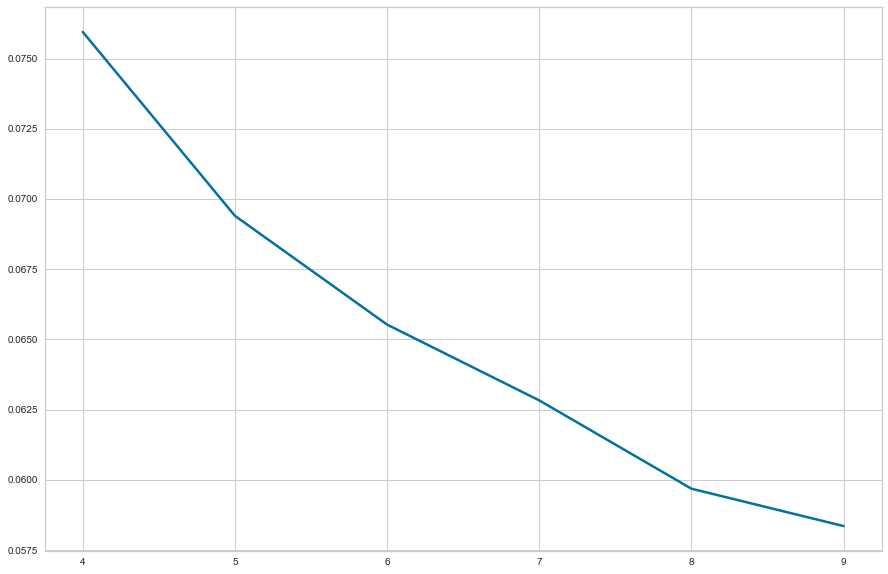

In [94]:
plt.figure(figsize=(15,10))
sns.lineplot(y=pr,x=k_n, palette="tab10", linewidth=2.5)
